# Laplacian Eigenvalues #

Writen by: Oscar Reula (oreula@gmail.com)

This code is used to compute the resonant frequencies and eigenvectors of a cavity. The model is 2-dimensional, that is it corresponds to infinite long structures in the  ẑ direction. 
This restriction is mainly due to have a code that can run in home computers in very short time.

First the theory: we need to solve the following eigenfuntion problem: 

\begin{align}
    \nabla \cdot \nabla u  = \lambda u \quad\quad\text{ in $\Omega$} \\
    u = 0 \text{ on $\partial\Omega$}
\end{align}

Where $\Omega$ is some 2-dimensional region. 


In order to use finite elements we need to express the problem as a weak one:

$$
\int_{\Omega} \nabla u\,\cdot \nabla v\, {\rm d} x
= \lambda \int_{\Omega} u \cdot v\, {\rm d} x \quad \forall  v \in H^1_0(\Omega),
$$



We shall incorporate a simple, known, case which we shall use to test the implementation, namely:

\begin{align}
    \nabla \cdot \nabla u  = \lambda u \quad \quad \text{ in $\Omega$ } \quad \quad \quad \\
    \Omega = (0,\pi) \times (0,\pi)
\end{align}


For this case we know the solutions: 

\begin{align}
    u_{n,m}(x,y) = \sin(n x)\sin(m y), \quad \lambda = m^2 + n^2, \quad \lambda = 2, 5, 5, 8, 10, 10, 13, 13, 17, 17, 18, \dots
\end{align}

We use this case to check that what we are doing is correct. 

Part of this code is addapted from: https://gist.github.com/Balaje/102485bb14ec6daf677f938fbd8f3ebb

In [1]:
import Pkg; Pkg.activate("../Tarea_5/gridap_makie")
using Gridap
using GridapMakie, GLMakie
using FileIO
#using Plots
#mkdir("models")
#mkdir("images")
using GridapGmsh
#using gmsh
using Gmsh
using LinearAlgebra
using SparseArrays
using SuiteSparse
using Arpack


  Activating project at `~/Docencia/PDE/pde/2022/Numéricos/Tarea_5/gridap_makie`


## Mesh Generation ##

We shall use some meshes which will be contructed in a script to be included below.
It has several grids which can be modified via the parameters or directly modifying the script. 
In particular we have this grids:

**rectangle:**
We shall use a square mesh for testing and then several ones for experimenting: 

**square with a circular hole:**
A square with a circular hole in its interior. It is centered on the square, but then one can experiment moving it from the center. What would happend?

**circle with a circular hole:**
You can also move the hole here.

With the boolean assignments you can choose between cases.

In [2]:
test = false #square 
rectangle = false
square_circle = false
circle_circle = false

test = true #square 
#rectangle = true
#square_circle = true
#circle_circle = true


true

In [3]:
# Create mesh 
include("models/mesh_generator.jl")

make_model (generic function with 1 method)

In [4]:
L = 1
displacement = 0.0
h = 10^(-1)

if test 
    grid_type = "test"
    p = (L*π,L*π, h) #for test (Length_x, Length_y, h) 
    boundary_tags = ["ext"]
    dirichlet_tags= ["ext"]
    dirichlet_values = 0.0 # 0.0+im*0.0
elseif rectangle
    grid_type = "rectangle"
    p = (L*π,L*π+displacement, h) #for test / rectangle (Length_x, Length_y, h) 
    boundary_tags = ["ext"]
    dirichlet_tags= ["ext"]
    dirichlet_values = 0.0 # 0.0+im*0.0
elseif square_circle
    grid_type = "square_circle"
    p = (π, π, 0.5*π, 0.5*π + displacement, 0.15*π, h) # for square_circle (Length_x, Length_y, circle_center_x, circle_center_y, radious)
    boundary_tags = ["circle", "ext"]
    dirichlet_tags= ["circle","ext"] 
    dirichlet_values = [0.0,0.0]
elseif circle_circle
    grid_type = "circle_circle"
    p = (0.0, 0.0, 0.5*π, 1.5*π, h) # for circle_circle (cy_center_x, cy_center_y, cy_inner_radious, cy_outer_radious)
    boundary_tags = ["inner","outer"]
    dirichlet_tags=["inner","outer"]
    dirichlet_values = [0.0,0.0]
end

model = make_model(grid_type, p)


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.112255s, CPU 0.00058s)
Info    : Meshing 2D...
Info    : Meshing surface 100 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.438853s, CPU 0.050845s)
Info    : 1266 nodes 2534 elements
Info    : Writing 'models/rectangle.msh'...
Info    : Done writing 'models/rectangle.msh'
Info    : Reading 'models/rectangle.msh'...
Info    : 9 entities
Info    : 1266 nodes
Info    : 2530 elements
Info    : Done reading 'models/rectangle.msh'


UnstructuredDiscreteModel()

We now define the triangulation and the measures, in the surface and in the boundary. Then plot them to make sure it is the region we want.

In [5]:
Ω = Triangulation(model)
degree = 3
dΩ = Measure(Ω,degree)

Measure()

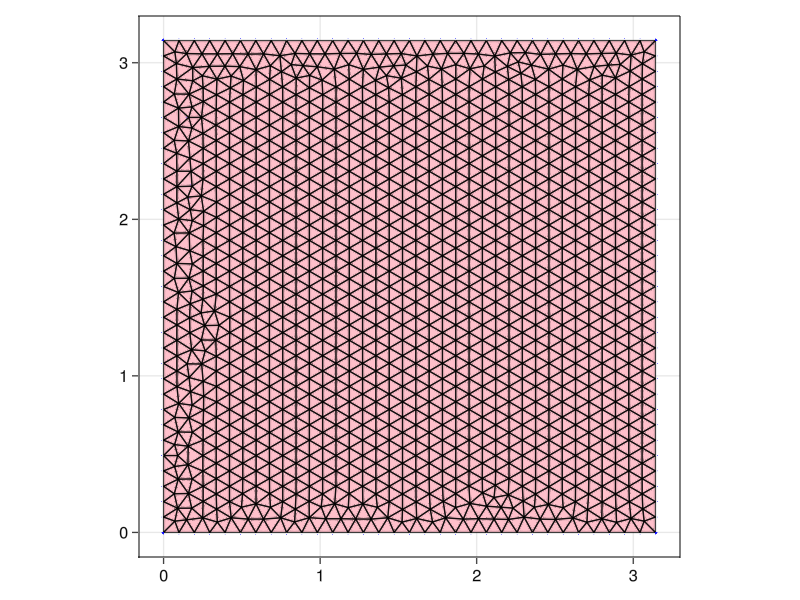

In [6]:
fig, ax = plot(Ω)
ax.aspect = AxisAspect(1) # this makes the region with fixed aspect, so it might not give the correct ratios
wireframe!(Ω, color=:black, linewidth=1)
scatter!(Ω, marker=:star8, markersize=4, color=:blue)
fig

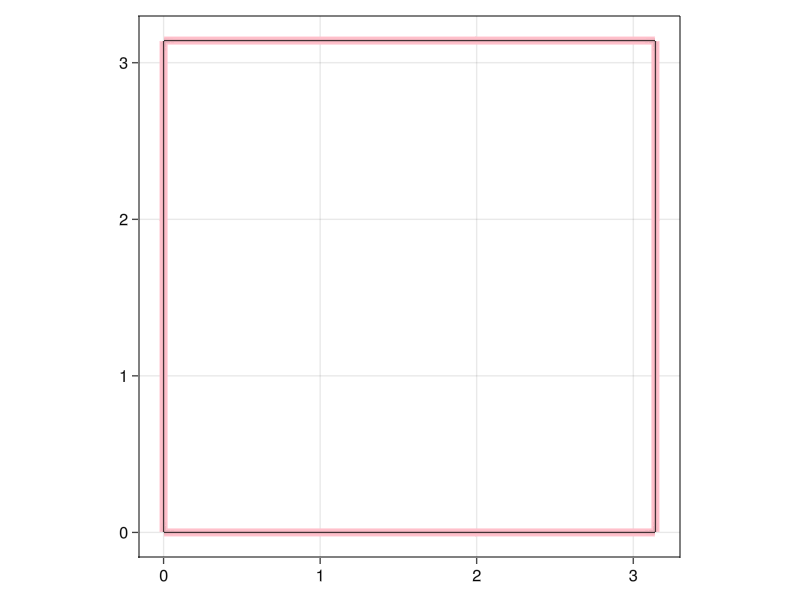

In [7]:
Γ = BoundaryTriangulation(model,tags=boundary_tags)
dΓ = Measure(Γ,degree)
fig, ax = plot(Γ, linewidth=8)
ax.aspect = AxisAspect(1)
wireframe!(Γ, color=:black, linewidth=1)
fig

In [8]:
order = 2
reffe = ReferenceFE(lagrangian,Float64,order)
V = TestFESpace(model,reffe;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags = dirichlet_tags)
U = TrialFESpace(V,dirichlet_values)


TrialFESpace()

In [9]:
a(u,v) = ∫( ∇(v)⋅∇(u) )*dΩ
m(u,v) = ∫(u*v)dΩ


m (generic function with 1 method)

In [10]:
include("eigen.jl")


solve (generic function with 1 method)

In [11]:
nev = 10 # number of eigenvalues asked to evaluate.
prob = EigenProblem(a, m, U, V; nev = nev)
ξ, uₕs = solve(prob);


We now can plot the eigen-functions. To do that we choose them using the index in which they are saved.

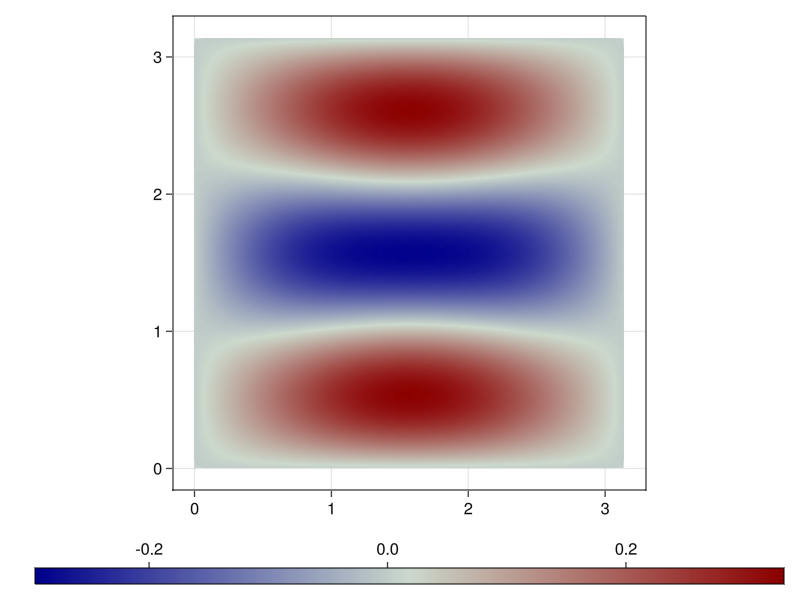

In [12]:
uₕ = uₕs[6]
fig, ax, plt = plot(Ω, real(uₕ))
ax.aspect = AxisAspect(1)
Colorbar(fig[2,1], plt, vertical=false)
fig

We can plot the eigenvalues:

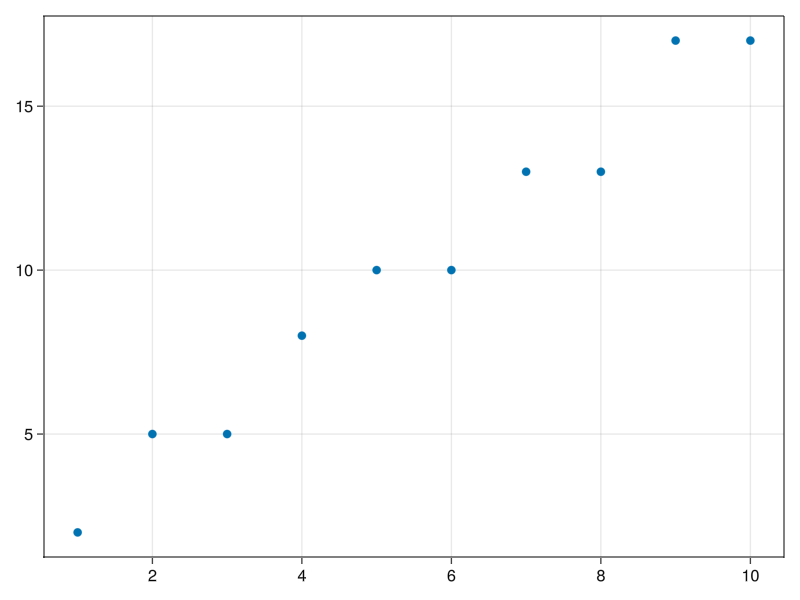

In [13]:
scatter(real(ξ))

In [14]:
ξ

10-element Vector{ComplexF64}:
 2.0000008569484926 - 9.00989722803829e-17im
  5.000012853942224 + 3.386059308691872e-17im
   5.00001368397489 - 5.676394025520967e-17im
  8.000054572609198 - 2.8429304701844033e-16im
 10.000103785697535 + 3.215870374723089e-16im
 10.000106791276433 - 2.7991802827405515e-16im
  13.00022676073986 - 2.4516133067382926e-17im
 13.000239252197412 - 4.2912680144197914e-17im
 17.000513706861113 + 2.116763078542817e-16im
 17.000514622162378 + 1.0069708470050675e-16im

For the test case we can compare with the correct values.

In [15]:
if test 
    [n^2 + m^2 for n = 1:5, m = 1:5]
end

5×5 Matrix{Int64}:
  2   5  10  17  26
  5   8  13  20  29
 10  13  18  25  34
 17  20  25  32  41
 26  29  34  41  50